# Joint model for cascades

In [45]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
import stan_utility
from joint_model_cascades import * 

## Forward model

Given a set of $K$ sources with known redshifts $z_k$, positions $\varpi_k$ and uniform luminosities $L$, simulate a neutrino data set. 

The neutrinos are produced at the source with spectrum ${\rm{d}}N/{\rm{d}}\tilde{E} \propto \tilde{E}^{-\alpha}$, they lose energy according to adiabatic expansion such that $\tilde{E} = (1+z)E$ and are detected with a simple uncertainty $\sigma_E$.

In [548]:
# Use a set of sources uniform in comoving volume for a lambda-CDM universe.
with h5py.File('data/test_SFR_pop.h5', 'r') as f:
    Ns = f['output/Ns'].value
    redshift = f['output/redshift'].value
    position = f['output/position'].value
    
# Select sources within redshift 0.5 to mimic catalogue
selection = np.where(redshift < 0.5)[0]

# Or randomly select
#np.random.seed(1)
#selection = np.random.choice(Ns, 10)

In [549]:
Ns = len(selection)
redshift = np.array([redshift[_] for _ in selection])
#redshift = np.array([3])
position = np.array([position[_] for _ in selection])

# Try ordering sources by redshift, as larger z => lower F
# This could help eliminate degeneracies in the mixture
inds = redshift.argsort()[::-1]
redshift = redshift[inds]
position = position[inds]
unit_vector = [p / np.linalg.norm(p) for p in position]

# Add background redshift
redshift = list(redshift) + [0.6]

In [550]:
Ns

3

In [551]:
# Use simple Aeff calculated in `arrival_direction_model/testing_simple_model.ipynb`.
# Just for testing, to be replaced with a better solution...
filename = 'data/IC79-2010-TabulatedAeff.txt'
effective_area = IceCubeAeff(filename, selected_E = 1E5) # GeV

# Exposure factor for sources in catalog
T = 1 # yr
eps = [] # m^2 yr

# Sources
for uv in unit_vector:
    zenith_angle = np.pi - np.arccos(uv[2])
    mk = effective_area.m(zenith_angle)
    eps.append(effective_area._Aeff_max * T * mk)   

# Isotropic background
eps.append(effective_area._Aeff_max * T * (effective_area.M / (4*np.pi)))
    
# Interpolation grid
zenith_grid = np.linspace(0, np.pi)
m_grid = [effective_area.m(z) for z in zenith_grid]

In [564]:
# Compile Stan model
sim = stan_utility.compile_model(filename = 'stan/joint_cascade_sim.stan', 
                                 model_name = 'nu_sim', include_paths = 'stan/')

Using cached StanModel


In [601]:
# Prepare simulation inputs
sim_input = {}

# Sources
sim_input['Ns'] = Ns
sim_input['z'] = redshift
dl = [luminosity_distance(z) for z in redshift[:-1]] # Mpc
sim_input['D'] = dl # Mpc
sim_input['varpi'] = unit_vector

# Energies
sim_input['alpha'] = 2.0
sim_input['Emin'] = 10 # TeV
sim_input['f_E'] = 0.1

# Deflection
sim_input['kappa'] = 100 # ~10 deg for cascades

# Associated fraction 
total_flux = 10 # m^-2 yr^-1
f = 0.8

Q = ( (f*total_flux) / (sum([1 / (4*np.pi * (d*Mpc_to_m)**2) for d in dl])) ) # yr^-1
F0 = (1 - f) * total_flux # m^-2 yr^-1

sim_input['Q'] = Q # yr^-1
sim_input['F0'] = F0 # m^-2 yr^-1

# Exposure
sim_input['eps'] = eps
sim_input['Ngrid'] = len(zenith_grid)
sim_input['zenith_grid'] = zenith_grid
sim_input['m_grid'] = m_grid

In [602]:
# Simulate
simulation = sim.sampling(data = sim_input, iter =1, chains = 1, 
                          algorithm = "Fixed_param")

In [603]:
# Extract output
from fancy.interfaces.stan import Direction
from fancy.plotting import AllSkyMap

# Arrival directions
event = simulation.extract(['event'])['event'][0]
event = Direction(event)
e_ra = event.d.icrs.ra.rad
e_dec = event.d.icrs.dec.rad

source = Direction(unit_vector)
s_ra = source.d.icrs.ra.rad
s_dec = source.d.icrs.dec.rad

# Energies
Esrc = simulation.extract(['Esrc'])['Esrc'][0]
E = simulation.extract(['E'])['E'][0]
Edet = simulation.extract(['Edet'])['Edet'][0]

In [604]:
# Labels
lam = simulation.extract(['lambda'])['lambda'][0] - 1
Nc = max(lam)
label_cmap = plt.cm.get_cmap('plasma', Nc+1)

lam = list(lam)
Nsrc = sum([lam.count(_) for _ in range(int(Nc))])
Nbg = lam.count(Nc)
print('Nsrc: ', Nsrc)
print('Nbg: ', Nbg)

Nsrc:  49
Nbg:  56


may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).WARNING:Error plotting coords [33.2567603912564 88.96913891753587] with radius 2


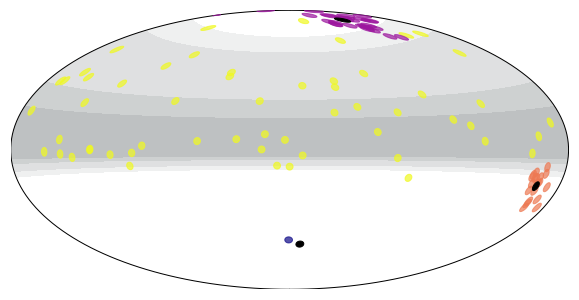

In [605]:
from matplotlib.colors import LinearSegmentedColormap
# Plot arrival directions
ras = np.linspace(-180, 180)
decs = np.linspace(-90, 90)
Aeff = [effective_area.m(np.pi/2 + np.deg2rad(d)) for d in decs]
Aeff = [Aeff for ra in ras]
dec, ra = np.meshgrid(decs, ras)
exp_cmap = LinearSegmentedColormap.from_list('custom',['#FFFFFF','#BEC1C2'],N=5)
fig, ax = plt.subplots()
fig.set_size_inches((10, 8))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);
skymap.contourf(ra, dec, Aeff, latlon = True, cmap = exp_cmap)
for r, d, l in zip(e_ra, e_dec, lam):
    color = label_cmap.colors[int(l)]
    skymap.tissot(np.rad2deg(r), np.rad2deg(d), 2, 30, color = color, alpha = 0.7)
for r, d in zip(s_ra, s_dec):
    skymap.tissot(np.rad2deg(r), np.rad2deg(d), 2, 30, color = 'black')

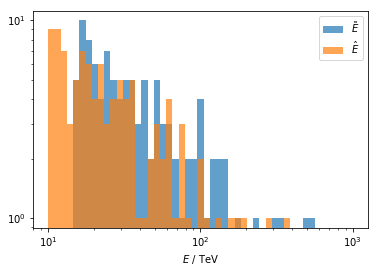

In [606]:
# Plot energies
Emin = sim_input['Emin']
bins = np.logspace(np.log(Emin), np.log(1E+2 * Emin), base = np.e)

fig, ax = plt.subplots()
ax.hist(Esrc, bins = bins, label = '$\\tilde{E}$', alpha = 0.7);
#ax.hist(E, bins = bins, label = '$E$', alpha = 0.7);
ax.hist(Edet, bins = bins, label = '$\hat{E}$', alpha = 0.7);
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / TeV')
ax.legend();

## Stan fit

In [607]:
# Compile the model
model = stan_utility.compile_model(filename = 'stan/joint_cascade_model.stan', 
                                   model_name = 'neutrino_model', 
                                   include_paths = 'stan/')

Using cached StanModel


In [608]:
# Prepare fit inputs
fit_input = {}
fit_input['N'] = len(event.unit_vector)
fit_input['omega_det'] = event.unit_vector
fit_input['Emin'] = sim_input['Emin']
fit_input['f_E'] = sim_input['f_E']
fit_input['Edet'] = Edet
fit_input['Ns'] = len(source.unit_vector)
fit_input['varpi'] = source.unit_vector
fit_input['D'] = sim_input['D']
fit_input['z'] = sim_input['z']
fit_input['eps'] = sim_input['eps']
fit_input['A_IC'] = effective_area._Aeff_max
fit_input['kappa'] = sim_input['kappa']

In [609]:
fit = model.sampling(data = fit_input, iter = 1000, chains = 4, seed = 19920715)

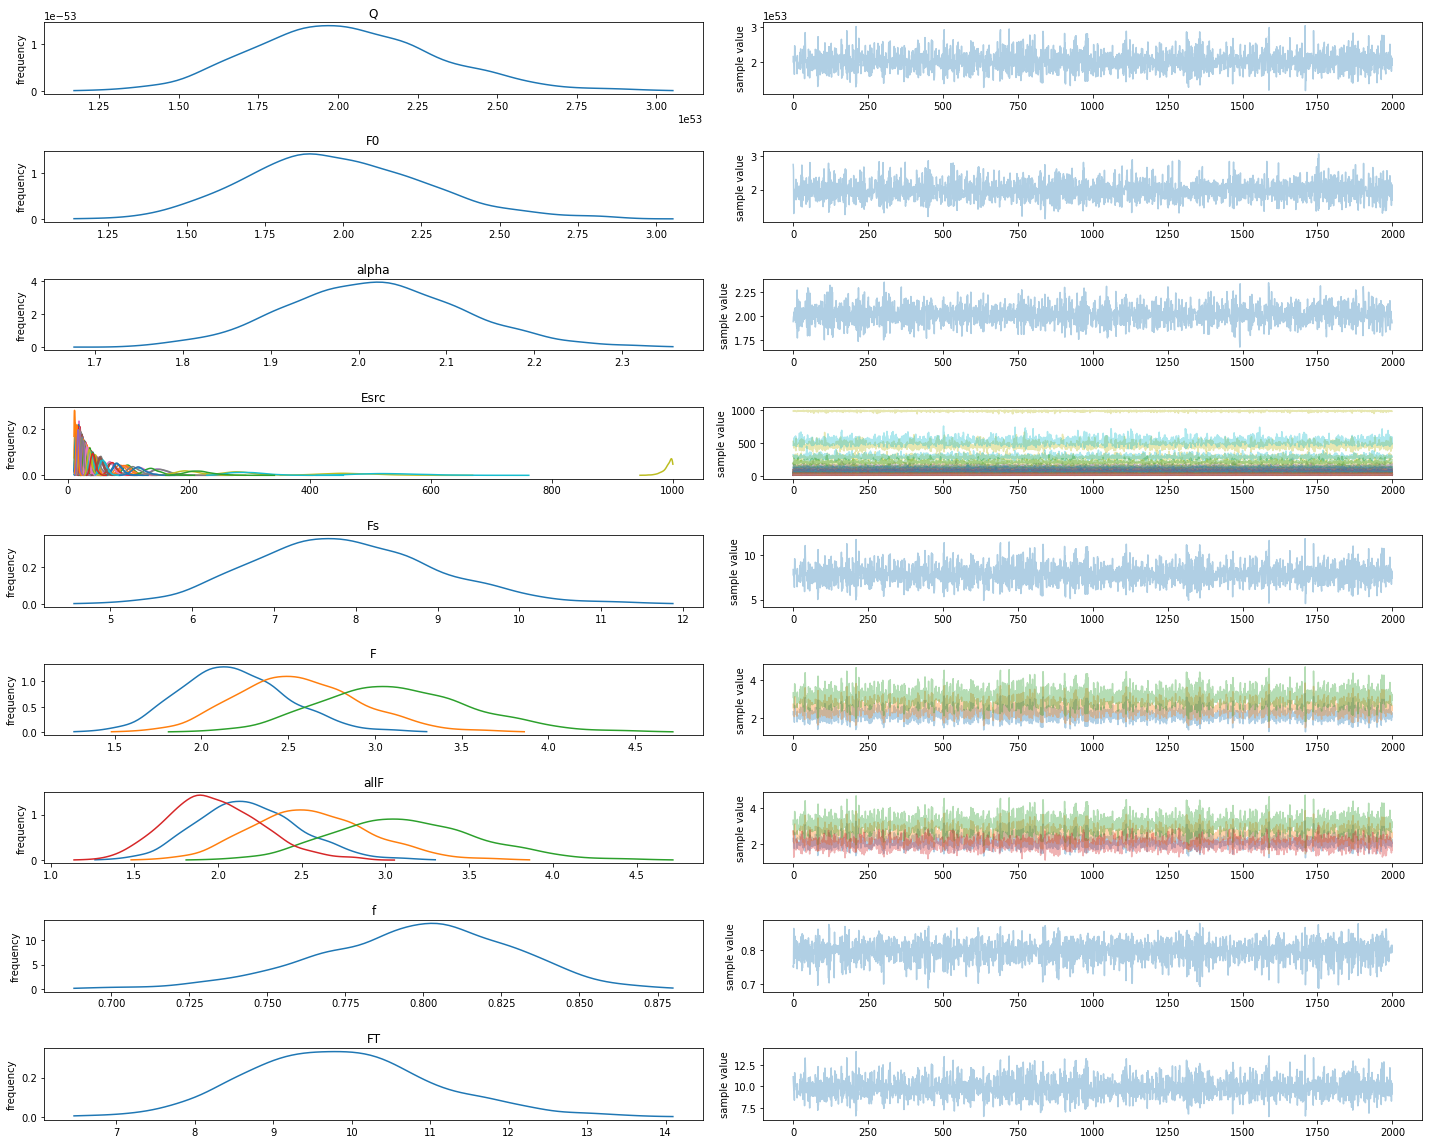

In [610]:
fig = fit.plot();
fig.set_size_inches(20, 16)
fig.tight_layout()

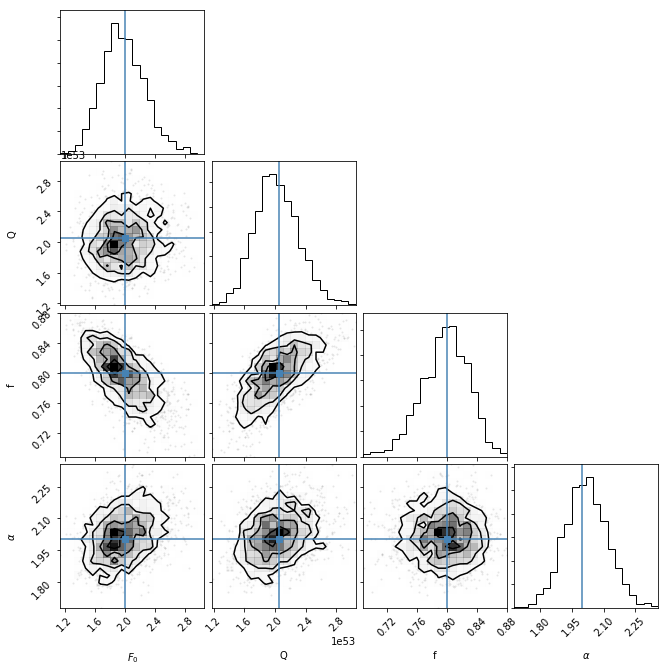

In [611]:
import corner
chain = fit.extract(permuted = True)
key_list = ['F0', 'Q', 'f', 'alpha']
labels = [r'$F_0$', r'Q', 'f', r'$\alpha$']
truths = [F0 , Q, f, sim_input['alpha']]

corner.corner(np.nan_to_num(np.column_stack([chain[key] for key in key_list])),
              labels = labels, 
              truths = truths);